In [2]:
!nvidia-smi

Sun Jan 21 05:50:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.146.02             Driver Version: 535.146.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                On  | 00000000:68:00.0 Off |                  Off |
| 33%   46C    P2              71W / 200W |    297MiB / 49152MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from glob import glob
import os
import pandas as pd

plt.style.use('seaborn-v0_8')


#フォント設定
# plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
#plt.rcParams['mathtext.fontset'] = 'stix' # math fontの設定
plt.rcParams["font.size"] = 50 # 全体のフォントサイズが変更されます。
plt.rcParams['xtick.labelsize'] = 15 # 軸だけ変更されます。
plt.rcParams['ytick.labelsize'] = 15 # 軸だけ変更されます


#軸設定
plt.rcParams['xtick.direction'] = 'in' #x軸の目盛りの向き
plt.rcParams['ytick.direction'] = 'in' #y軸の目盛りの向き
#plt.rcParams['axes.grid'] = True # グリッドの作成
#plt.rcParams['grid.linestyle']='--' #グリッドの線種
#plt.rcParams["xtick.minor.visible"] = True  #x軸補助目盛りの追加
#plt.rcParams["ytick.minor.visible"] = True  #y軸補助目盛りの追加
#plt.rcParams['xtick.top'] = True  #x軸の上部目盛り
#plt.rcParams['ytick.right'] = True  #y軸の右部目盛り


#軸大きさ
plt.rcParams["xtick.major.width"] = 1.0             #x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1.0             #y軸主目盛り線の線幅
plt.rcParams["xtick.minor.width"] = 1.0             #x軸補助目盛り線の線幅
plt.rcParams["ytick.minor.width"] = 1.0             #y軸補助目盛り線の線幅
plt.rcParams["xtick.major.size"] = 10               #x軸主目盛り線の長さ
plt.rcParams["ytick.major.size"] = 10               #y軸主目盛り線の長さ#
plt.rcParams["xtick.minor.size"] = 5                #x軸補助目盛り線の長さ
plt.rcParams["ytick.minor.size"] = 5                #y軸補助目盛り線の長さ
plt.rcParams["axes.linewidth"] = 1.0                #囲みの太さ


#凡例設定
plt.rcParams["legend.fancybox"] = False  # 丸角OFF
plt.rcParams["legend.framealpha"] = 1  # 透明度の指定、0で塗りつぶしなし
plt.rcParams["legend.edgecolor"] = 'black'  # edgeの色を変更
plt.rcParams["legend.markerscale"] = 20 #markerサイズの倍率


from model import OnlyMLP
from utils import *

In [19]:
class Exp(object):
    def __init__(self) -> None:
        # Learning Parameter
        self.lr=1e-3 
        self.weight_decay =  0.0
        self.p=67 
        self.d_emb = 500
        self.d_model =  48
        self.is_symmetric_input = False

        # Stop training when test loss is <stopping_thresh
        self.stopping_thresh = -1
        self.seed = 1
        self.is_div = False


        self.num_layers = 0
        self.batch_style = 'full' # ['full', 'random'] 
        self.d_vocab = self.p
        self.n_ctx = 2
        self.d_mlp = 1*self.d_model
        self.num_heads = 1
        assert self.d_model % self.num_heads == 0
        self.d_head = self.d_model//self.num_heads  
        self.act_type = 'ReLU'  # ['ReLU', 'GELU']
        self.weight_scale = 1 #0.5576312536233431
        self.prune_rate = 0.4                               
        self.weight_ratio = -1#0.6493382079831002 #0.4152939027995708
        self.fn_name = 'add'

        self.use_ln = False

        self.random_answers = np.random.randint(low=0, high=self.p, size=(self.p, self.p))

        self.fns_dict = {'add': lambda x,y:(x+y)%self.p} 
                        # 'subtract': lambda x,y:(x-y)%self.p, \
                        #  'x2xyy2':lambda x,y:(x**2+x*y+y**2)%self.p, 'rand':lambda x,y:self.random_answers[x][y],\
                        #   "only_add": lambda x,y:(x+y)}
        self.fn = self.fns_dict[self.fn_name]
        
        # pruning
        self.pruner = "mag" # ["rand", "mag", "snip", "grasp", "synflow"]
        self.sparsity = 0.4 #0.7 #0.29#0.4#0.598#1#0.3
        self.schedule = "linear" # ["linear", "exponential"]
        self.scope = "global" # ["global", "local"]
        self.epochs =  1           
        self.reinitialize =  True
        self.train_mode = False
        self.shuffle = False
        self.invert = False
        if self.is_symmetric_input:
            self.batch_size =  (self.p**2 - self.p)//2
        else:
            self.batch_size =  self.p**2

# memorize density

name:init, train_acc: 0.012291483581066132, test_acc: 0.01404741033911705, spasity:0.8487826086956521, epsilon:0.13555063009262086
name:0, train_acc: 0.022827042266726494, test_acc: 0.010535557754337788, spasity:0.8489826086956521, epsilon:0.13561501502990722
name:200, train_acc: 1.0, test_acc: 0.007023705169558525, spasity:0.6945739130434783, epsilon:0.14022519588470458
name:400, train_acc: 1.0, test_acc: 0.007023705169558525, spasity:0.5738434782608696, epsilon:0.12237186431884767
name:600, train_acc: 1.0, test_acc: 0.021071115508675575, spasity:0.45741739130434783, epsilon:0.1076249122619629
name:800, train_acc: 1.0, test_acc: 0.04302019253373146, spasity:0.3625217391304348, epsilon:0.09481001496315003
name:1000, train_acc: 1.0, test_acc: 0.06672520190477371, spasity:0.2978173913043478, epsilon:0.08486900329589844
name:1200, train_acc: 1.0, test_acc: 0.10184372216463089, spasity:0.28374782608695653, epsilon:0.08260533809661866
name:1400, train_acc: 1.0, test_acc: 0.13432836532592773

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [Text(0, 0, '0'),
  Text(1, 0, '200'),
  Text(2, 0, '400'),
  Text(3, 0, '600'),
  Text(4, 0, '800'),
  Text(5, 0, '1000'),
  Text(6, 0, '1200'),
  Text(7, 0, '1400'),
  Text(8, 0, '1600'),
  Text(9, 0, '1800'),
  Text(10, 0, '2000'),
  Text(11, 0, '2200'),
  Text(12, 0, '2400'),
  Text(13, 0, '2600'),
  Text(14, 0, '2800'),
  Text(15, 0, '3000'),
  Text(16, 0, '3200'),
  Text(17, 0, '3400'),
  Text(18, 0, '3600'),
  Text(19, 0, '3800'),
  Text(20, 0, '4000'),
  Text(21, 0, '4200'),
  Text(22, 0, '4400'),
  Text(23, 0, '4600'),
  Text(24, 0, '4800'),
  Text(25, 0, '5000'),
  Text(26, 0, '5200'),
  Text(27, 0, '5400'),
  Text(28, 0, '5600'),
  Text(29, 0, '5800'),
  Text(30, 0, '6000'),
  Text(

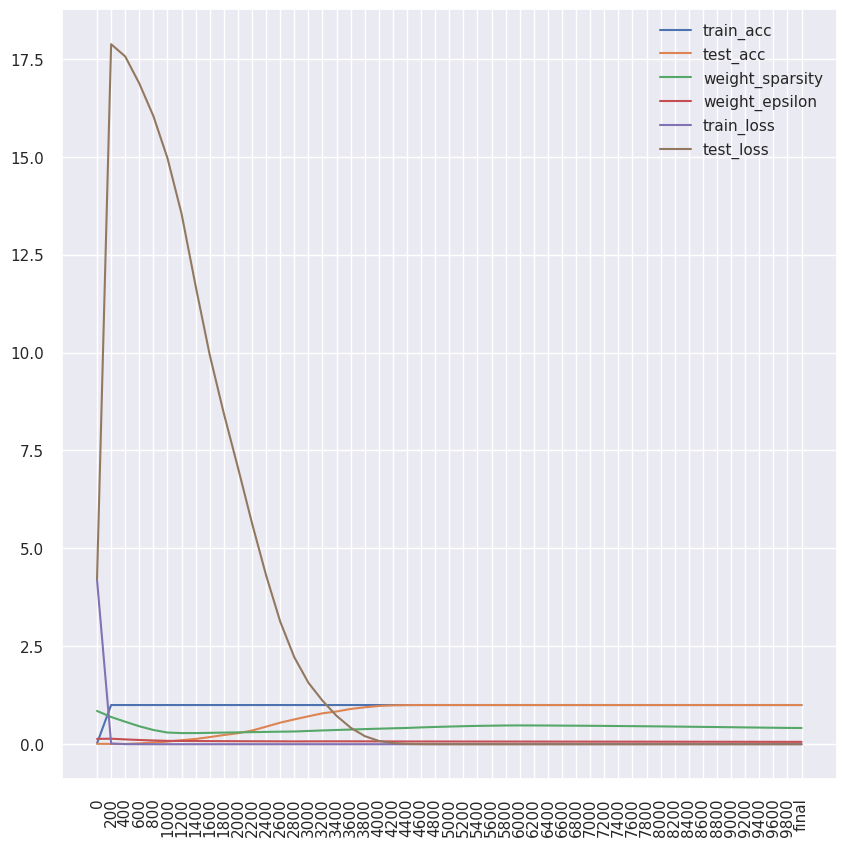

In [23]:
weight_paths = glob(os.path.join("/home/0120/detail/WIDTH_48","*"))
res_dic = {}
for weight_path in weight_paths:
    name = weight_path.split("/")[-1].split(".")[0]
    if "init" in name:
        train = torch.load(weight_path)["train_data"]
        test = torch.load(weight_path)["test_data"]
        
    config = Exp()
    model = OnlyMLP(num_layers=config.num_layers, d_vocab=config.d_vocab, \
                            d_model=config.d_model, d_emb=config.d_emb, \
                            act_type=config.act_type,  use_ln=config.use_ln, \
                            weight_scale=config.weight_scale)
    model.load_state_dict(torch.load(weight_path)["model"])
    model.to("cuda:0")
    train_loss, train_acc, train_prob, train_sample = full_loss_mlp(
    model, train, config.fn, config.p, is_div=config.is_div, device="cuda:0", vis=False
    )
    test_loss, test_acc, test_prob, test_sample = full_loss_mlp(
        model, test, config.fn, config.p, is_div=config.is_div, device="cuda:0", vis=False
    )
    k = 0.2
    total_weight = torch.cat([model.state_dict()["embed.W_E"].flatten(),model.state_dict()["inproj.W"].flatten(),model.state_dict()["outproj.W"].flatten(),model.state_dict()["unembed.W_U"].flatten()], dim=0)
    weight_epsilon = total_weight.abs().max().item()*k
    weight_sparsity = torch.sum(total_weight.abs() < weight_epsilon).item()/total_weight.numel()
    print("name:{}, train_acc: {}, test_acc: {}, spasity:{}, epsilon:{}".format(name,train_acc,test_acc, weight_sparsity, weight_epsilon))
    if not ("init" or "final") in name:
        res_dic[name] = [train_acc, test_acc, weight_sparsity, weight_epsilon, train_loss.cpu().detach().numpy(), test_loss.cpu().detach().numpy()]

plt.figure(figsize=(10,10))
plt.plot(np.array(list(res_dic.keys())), np.array(list(res_dic.values()))[:,0], label="train_acc")
plt.plot(np.array(list(res_dic.keys())), np.array(list(res_dic.values()))[:,1], label="test_acc")
plt.plot(np.array(list(res_dic.keys())), np.array(list(res_dic.values()))[:,2], label="weight_sparsity")
plt.plot(np.array(list(res_dic.keys())), np.array(list(res_dic.values()))[:,3], label="weight_epsilon")
plt.plot(np.array(list(res_dic.keys())), np.array(list(res_dic.values()))[:,4], label="train_loss")
plt.plot(np.array(list(res_dic.keys())), np.array(list(res_dic.values()))[:,5], label="test_loss")
plt.legend()
plt.xticks(rotation=90)

# To excavate a generalized solution.

In [32]:
fig, ax = plt.subplots(10,5, figsize=(10,20))
gene_weight_path = "/home/0120/detail/WIDTH_48/final.pth"
for i in range(5):
    for j in range(10):
        memo_weight_path = f"/home/0120/detail/WIDTH_48/{200*(i*10+j)}.pth"

        gene_model = OnlyMLP(num_layers=config.num_layers, d_vocab=config.d_vocab, \
                                    d_model=config.d_model, d_emb=config.d_emb, \
                                    act_type=config.act_type,  use_ln=config.use_ln, \
                                    weight_scale=config.weight_scale)
        gene_model.load_state_dict(torch.load(gene_weight_path)["model"])
        gene_model.to("cuda:0")
        global_pruning_rates = np.arange(0, 1.0, 0.01)
        pruned_test_accs = []
        pruned_train_accs = []
        for global_pruning_rate in global_pruning_rates:
            gene_weight_mask = gene_model.state_dict()
            gene_weight = {}
            gene_mask = {}

            for key, value in gene_weight_mask.items():
                if "W" in key:
                    gene_weight[key] = value
                elif "mask" in key:
                    gene_mask[key] = value
                    

            for gw, gm in zip(gene_weight.values(), gene_mask.values()):
                gm[gw.abs() < global_pruning_rate*gw.abs().max()] = 0

                
            memo_model = OnlyMLP(num_layers=config.num_layers, d_vocab=config.d_vocab, \
                                        d_model=config.d_model, d_emb=config.d_emb, \
                                        act_type=config.act_type,  use_ln=config.use_ln, \
                                        weight_scale=config.weight_scale)
            
            memo_model.load_state_dict(torch.load(memo_weight_path)["model"])
            memo_model.to("cuda:0")
            memo_weight_mask = memo_model.state_dict()
            memo_weight = {}
            memo_mask = {}
            
            test_loss, test_acc, test_prob, test_sample = full_loss_mlp(
                memo_model, test, config.fn, config.p, is_div=config.is_div, device="cuda:0", vis=False
            )

            original_test_acc = test_acc
            
            train_loss, train_acc, train_prob, train_sample = full_loss_mlp(
                memo_model, train, config.fn, config.p, is_div=config.is_div, device="cuda:0", vis=False
            )
            original_train_acc = train_acc
        # print("memo_acc_original:{}".format(test_acc))

            for key, value in memo_weight_mask.items():
                if "W" in key:
                    memo_weight[key] = value
                elif "mask" in key:
                    memo_mask[key] = value

            for key in memo_weight_mask:
                if "mask" in key:
                    memo_weight_mask[key] = gene_mask[key]

            memo_model.load_state_dict(memo_weight_mask)

            test_loss, test_acc, test_prob, test_sample = full_loss_mlp(
                memo_model, test, config.fn, config.p, is_div=config.is_div, device="cuda:0", vis=False
            )

            #print("memo_acc_pruned:{}".format(test_acc))
            pruned_test_accs.append(test_acc)
            
            train_loss, train_acc, train_prob, train_sample = full_loss_mlp(
                memo_model, train, config.fn, config.p, is_div=config.is_div, device="cuda:0", vis=False
            )
            
            pruned_train_accs.append(train_acc)
            

        ax[i][j].plot(global_pruning_rates, pruned_test_accs, label="pruned_test_acc", color="red")
        ax[i][j].hlines(original_test_acc, 0,1, label="original_test_acc", color="blue")
        ax[i][j].plot(global_pruning_rates, pruned_train_accs, label="pruned_train_acc", color="red", linestyle="dashed")
        ax[i][j].hlines(original_train_acc, 0,1, label="original_train_acc", color="blue", linestyle="dashed")
        # ax[i][j].legend()
        # ax[i][j].xlabel("global_pruning_rate")
        # ax[i][j].ylabel("accuracy")